In [7]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import ROOT
import pandas as pd
from dataclasses import make_dataclass

In [8]:
def read_logscan(logfile):
    """This function is used to read logfiles generated by qnFit/sort.sh.
    To read the nll, file id and fit status into a dataframe.

    Args:
        logfile (_type_): _description_

    Returns:
        dataframe: _description_
    """
    # mass: bootstrapping file; id: fit result index; nll: NLL; status;
    one_log = make_dataclass("one_log", [("mass", float), ("id", str), ("nll",float), ("status", str)])
    df1 = pd.DataFrame()
    f1 = open(logfile,"r+")
    for l1 in f1:
        nll_temp = l1.split()[1]
        mass_temp = l1.split()[0].split("//")[1].split("-")[1]
        id_temp = l1.split()[0].split("//")[1].split("-")[2].split(".")[0]
        status_temp = l1.split()[3]
        df1 = df1.append([one_log(float(mass_temp), str(id_temp), float(nll_temp), str(status_temp))], ignore_index=True)
    return df1
def read_reverse_order(file_name):
    """Copied from website. Read a file from the end in a quick way

    Args:
        file_name (_type_): _description_

    Yields:
        _type_: _description_
    """
    # Open file for reading in binary mode
    with open(file_name, 'rb') as read_obj:
        # Move the cursor to the end of the file
        read_obj.seek(0, os.SEEK_END)
        # Get the current position of pointer i.e eof
        pointer_location = read_obj.tell()
        # Create a buffer to keep the last read line
        buffer = bytearray()
        # Loop till pointer reaches the top of the file
        while pointer_location >= 0:
            # Move the file pointer to the location pointed by pointer_location
            read_obj.seek(pointer_location)
            # Shift pointer location by -1
            pointer_location = pointer_location -1
            # read that byte / character
            new_byte = read_obj.read(1)
            # If the read byte is new line character then it means one line is read
            if new_byte == b'\n':
                # Fetch the line from buffer and yield it
                yield buffer.decode()[::-1]
                # Reinitialize the byte array to save next line
                buffer = bytearray()
            else:
                # If last read character is not eol then add it in buffer
                buffer.extend(new_byte)
        # As file is read completely, if there is still data in buffer, then its the first line.
        if len(buffer) > 0:
            # Yield the first line too
            yield buffer.decode()[::-1]

In [9]:
def read_fitParam(temp_file):
    i = 0
    temp_dict = {}
    for line in read_reverse_order(temp_file):
        if i<870:
            i += 1
            continue
        elif i>=870 and i<=946:
            i += 1
            temp_dict[line.split()[1]] = line.split()[2]
        elif i>946:
            i += 1
            break
        else:
            i += 1
            continue
    return temp_dict
def cal_asym_std(df_input, mean_input):
    if df_input.empty:
        return -999
    else:
        return sqrt(pow(df_input - mean_input,2).sum()/df_input.size)

In [15]:
#files = ["1p","1m","3p","3m","5p","5m"]
#for jp in files:
#    df_1p = read_logscan("/disk401/lhcb/qinning/b2dpp_farm10/qnFit/logscan_model0/check_{}.txt".format(jp))
#    df_groupby = df_1p[["mass","nll"]].groupby("mass")[["nll"]].min()
#    df_merge = pd.merge(df_groupby, df_1p, how="left", on=["mass","nll"])
#    df_merge = df_merge.groupby("mass").first().reset_index()
#    print(df_merge.head())
#    print(df_merge.shape)
#    df_FF = pd.DataFrame(read_fitParam("test.log"), index=[0])
#    for number in range(len(df_merge)):
#        temp_file = "logscan_{}/fit-{:.3f}-{}.log".format(jp,df_merge["mass"][number], df_merge["id"][number])
#        temp_dict = read_fitParam(temp_file)
#        temp_dict["mass"] = df_merge["mass"][number]
#        temp_dict["id"] = df_merge["id"][number]
#        temp_dict["JP"] = jp
#        df_FF = df_FF.append(temp_dict, ignore_index=True)
#    df_FF = df_FF.drop([0])
#    df_FF.to_csv("temp_{}.csv".format(jp), index=False) 

    mass      nll    id status
0  2.800 -11135.8  0006    NOT
1  2.805 -11137.8  0015    NOT
2  2.810 -11134.5  0026    NOT
3  2.815 -11138.5  0035    NOT
4  2.820 -11137.5  0042    NOT
(100, 4)


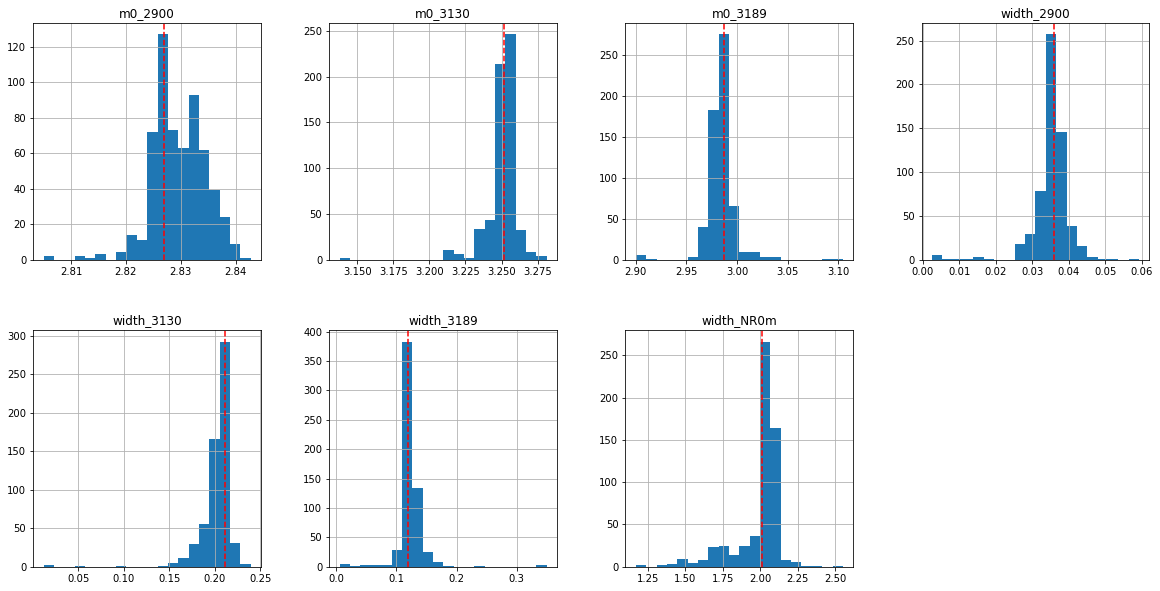

In [11]:
dict_trueValue = {"m0_2900":2.827, "m0_3130":3.252, "m0_3189":2.987, "width_2900":0.036, "width_3130":0.211, "width_3189":0.120, "width_NR0m":2.01}
df_all = pd.read_csv("./allScanParameters.csv")
title = ["m0_2900","m0_3130","m0_3189","width_2900","width_3130","width_3189","width_NR0m"]
df_toplot = df_all[title]
plots_param = df_toplot.hist(layout=(2,4),sharex=False,sharey=False,figsize=(20,10),bins=20)
for i in range(len(plots_param)):
    for ax in plots_param[i]:
        if ax.get_title() == "":
            continue
        ax.axvline(dict_trueValue[ax.get_title()], color="red", linestyle="--")

In [12]:
list_up = []
list_lo = []
for key,value in dict_trueValue.items():
    df_all_up = df_all[df_all[key] > value][key]
    df_all_lo = df_all[df_all[key] < value][key]
    list_up.append(cal_asym_std(df_all_up, value))
    list_lo.append(cal_asym_std(df_all_lo, value))
i = 0
for key,value in dict_trueValue.items():
    temp_FF = "$" + "{:.3f}".format(value) + "^{+" + "{:.3f}".format(list_up[i]) +"}" + "_{-" + "{:.3f}".format(list_lo[i]) +"}$ "
    line = "{:<15} & {:<30} \\\\".format(key, temp_FF)
    print(line)
    i = i+1


m0_2900         & $2.827^{+0.006}_{-0.004}$      \\
m0_3130         & $3.252^{+0.006}_{-0.015}$      \\
m0_3189         & $2.987^{+0.015}_{-0.015}$      \\
width_2900      & $0.036^{+0.004}_{-0.006}$      \\
width_3130      & $0.211^{+0.007}_{-0.023}$      \\
width_3189      & $0.120^{+0.027}_{-0.019}$      \\
width_NR0m      & $2.010^{+0.075}_{-0.275}$      \\
